# Introduction

Due to the one-and-a-half-year epidemic, global vaccine research and development attracts the attention of each country. Different methods for developing vaccines have been tested in these few years. However, all the vaccines aim are to make the human body produces antigen-specific antibodies. Then how to find out the antigen becomes the most significant part. The subregion of antigen proteins is called epitope regions, which helps B-cell inducing antigen-specific immune responses in vivo. By recognizing the epitope regions of antigen proteins – the part of an antigen molecule to which antibody attaches itself, they produce large amounts of antigen-specific antibodies that inhibit antigen protein function.  

Therefore, the computer-based automated prediction of epitope regions is extremely beneficial for developing vaccines to induce antigen-specific antibody production. It is currently one of the key research topics in vaccine development that will be widely useful for future medical data analysis. In conventional, the method to predict epitope cost huge labor, money, and time, like conducting three-dimensional structures and analyzing the antigen by X-ray or nuclear magnetic resonance (NMR) spectroscopy and focused only on the target sequence in the amino acid sequences of an entire antigen protein and have not thoroughly considered its sequence and features as a whole.

In this project, we will show several prediction methods of how to predict B-cell epitope and SARS to consider the characteristics of a whole antigen protein in addition to the target sequence.


# Data 

We used the existing dataset, which combines information extracted from both the Immune Epitope Database (IEDB), a free epitope database and prediction resource, as well as Universal Protein Resource (UniProt) – a comprehensive collection of protein sequences and their annotations. As a result, there are two data files, one for B-Cell, and one for SARS.

The B-Cell and SARS dataset consist of an activity label which indicates – based on the number of antigen-binding sites (0 or 1) – whether a peptide exhibits antibody-inducing activity, as well as other non-class attributes: parent protein ID, parent protein sequence, start/end positions of the peptide, peptide sequence, 4 peptide features: the possibility of β turn is calculated by chou_fasman method, which helps to analyze the relative frequency of amino acid; use emini to get relative surface accessibility that represents the surface area of a biomolecule that is enabled to access to a solvent; Antigenicity, refers to an interaction between antigenic determinants (epitopes) and antibodies or specific T cell receptor for antigen; Hydrophobicity, means insoluble in water, do not across and maximum the contact the water, the opposite of hydrophilic. Also, there are 4 protein features, one is the isoelectric point, which represents the pH when the molecule carries no net electrical charge; Aromaticity allows the electrons in the molecule to be delocalized around the ring, increasing the molecule's stability; Hydrophobicity is the same as peptide feature; Stability, defined as the quality of maintaining a constant character in the presence of forces that resistance to change. The total number of records is 14387 for the B cell (training) dataset and 520 for the SARS (test) dataset. Presented antibody proteins were restricted to Immunoglobulin G (IgG), the most recorded antibody type in IEDB, and records that represent different quantitative measures of antibody activity for the same peptide had been excluded for convenience. 

## Data Exploration

In [ ]:
# Clone fro Github
! git clone https://github.com/Ironarrow98/Bcell_data

Cloning into 'Bcell_data'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (4/4), done.


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

bcell = pd.read_csv("/content/Bcell_data/input_bcell.csv")
sars = pd.read_csv("/content/Bcell_data/input_sars.csv")

In both B-Cell and SARS datasets, one-third of data targets are 1, the most target is 0, which shows the target shares the same distribution, however, it is un-balance. 

Text(0.5, 1.0, 'Target frequency: SARS')

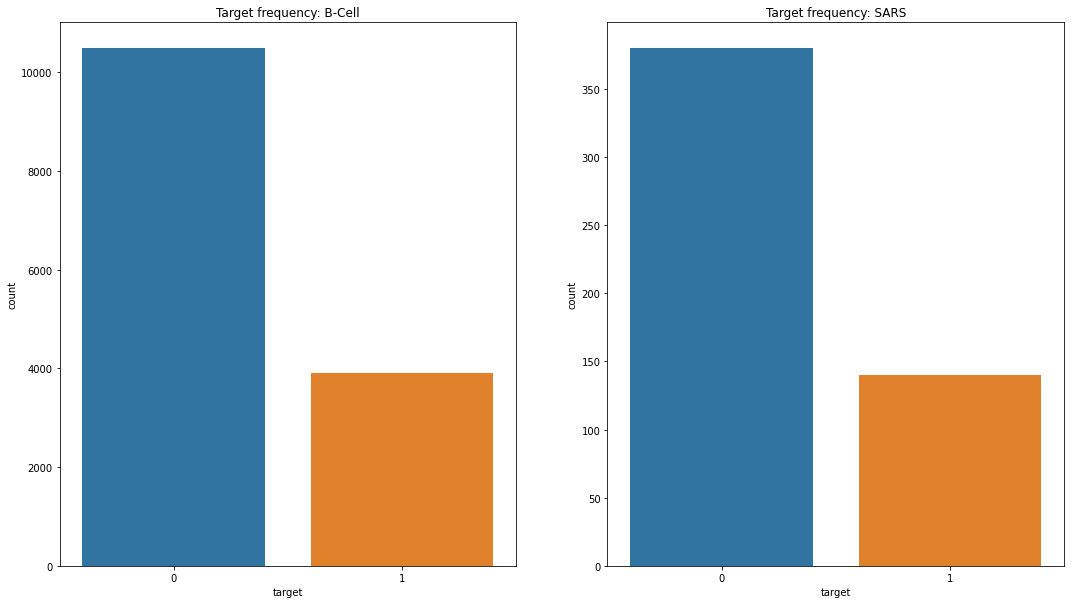

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (18, 10))

sns.countplot(data = bcell, x = "target", ax = axes[0])
axes[0].set_title('Target frequency: B-Cell')

sns.countplot(data = sars, x = "target", ax = axes[1])
axes[1].set_title('Target frequency: SARS')

we add a new column because we think the length of each peptide may have influence on prediction accuracy


In [ ]:
# create length columns
bcell["length"] = bcell["end_position"] - bcell["start_position"] + 1
sars["length"] = sars["end_position"] - sars["start_position"] + 1

Since each peptide has different length and amino acid, we use one-hot encoding method to transfer both peptide in bcell and sars into matrix with 0 and 1

In [ ]:
from keras.utils.np_utils import to_categorical

bcell_peptide = bcell['peptide_seq'].to_list()
sars_peptide = sars['peptide_seq'].to_list()

n = len(max(bcell_peptide + sars_peptide, key = len))

amino_acids = ['G', 'A', 'S', 'T', 'C', 'V', 'L', 'I', 'M', 'P', 'F', 'Y', 'W', 'D', 'E', 'N', 'Q', 'H', 'K', 'R']

# last one is for 4-dimension 
bcell_input_profile = np.zeros((len(bcell_peptide), n, 20, 1))

i = 0
while i < ((len(bcell_peptide))):
  pep = bcell_peptide[i]
  m = len(pep)
  for j in range(m):
    acid = pep[j]
    bcell_input_profile[i][j][amino_acids.index(acid)] = 1
  i += 1

bcell_target = to_categorical(bcell['target'], 2)


sars_input_profile = np.zeros((len(sars_peptide), n, 20, 1))

i = 0
while i < ((len(sars_peptide))):
  pep = sars_peptide[i]
  m = len(pep)
  for j in range(m):
    acid = pep[j]
    sars_input_profile[i][j][amino_acids.index(acid)] = 1
  i += 1

sars_target = to_categorical(sars['target'], 2)

## Feature Engineering

We build a model with two convolution layers, two maxpooling layer and two dense layer to extract the feature from the peptide sequence through nonlinear process. The extracted feature map from the peptide sequqnce will be combined with the original features for future classification. 

In [ ]:
# CNN model
import keras
import tensorflow as tf
from keras.datasets import cifar10
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Bidirectional, LSTM, Dropout, Dense

batch_size = 32
epochs = 100

model = Sequential()
model.add(Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=(n, 20, 1)))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))

model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu', name ='feature_dense'))
model.add(Dropout(0.5))
model.add(Flatten())
# process output
model.add(Dense(2, activation='sigmoid'))

# Compile the model before using it
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# create a callback that will save the best model while training
best_model = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='auto', save_best_only=True, verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 391, 18, 64)       640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 195, 9, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 195, 9, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 193, 7, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 96, 3, 32)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 96, 3, 32)         0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0

In [ ]:
bcell_history = model.fit(bcell_input_profile, bcell_target, validation_split=0.33, 
                          callbacks=[best_model], batch_size=batch_size, epochs=epochs)

bcell_model = load_model('best_model.h5')
intermediate_layer_model = Model(inputs=bcell_model.input, outputs=bcell_model.get_layer('feature_dense').output)
intermediate_layer_model.summary()

#predict to get featured data
bcell_feauture_engg_data = intermediate_layer_model.predict(bcell_input_profile)
bcell_feauture_engg_data = pd.DataFrame(bcell_feauture_engg_data)
print('feauture_engg_data shape:', bcell_feauture_engg_data.shape)
bcell_feauture_engg_data.head(5) 

Epoch 1/100
302/302 [==============================] - 19s 10ms/step - loss: 0.6233 - accuracy: 0.7184 - val_loss: 0.6141 - val_accuracy: 0.7481

Epoch 00001: val_loss improved from inf to 0.61411, saving model to best_model.h5
Epoch 2/100
302/302 [==============================] - 2s 8ms/step - loss: 0.5912 - accuracy: 0.7193 - val_loss: 0.6128 - val_accuracy: 0.7481

Epoch 00002: val_loss improved from 0.61411 to 0.61276, saving model to best_model.h5
Epoch 3/100
302/302 [==============================] - 2s 8ms/step - loss: 0.5825 - accuracy: 0.7193 - val_loss: 0.6024 - val_accuracy: 0.7481

Epoch 00003: val_loss improved from 0.61276 to 0.60237, saving model to best_model.h5
Epoch 4/100
302/302 [==============================] - 2s 8ms/step - loss: 0.5791 - accuracy: 0.7193 - val_loss: 0.5964 - val_accuracy: 0.7481

Epoch 00004: val_loss improved from 0.60237 to 0.59645, saving model to best_model.h5
Epoch 5/100
302/302 [==============================] - 2s 8ms/step - loss: 0.5713 

,0,1,2,3,4,5,6,7
0,0.012633,0.0,0.0,0.0,0.0,0.010656,0.092821,0.110623
1,0.053297,0.0,0.0,0.0,0.0,0.024144,0.252755,0.285477
2,0.000000,0.0,0.0,0.0,0.0,0.094587,0.034417,0.109501
3,0.000000,0.0,0.0,0.0,0.0,0.089293,0.000000,0.000000
4,0.000000,0.0,0.0,0.0,0.0,0.089293,0.000000,0.000000


In [ ]:
sars_history = model.fit(sars_input_profile, sars_target, validation_split=0.33, 
                         callbacks=[best_model], batch_size=batch_size, epochs=epochs)

sars_model = load_model('best_model.h5')
intermediate_layer_model = Model(inputs=sars_model.input, outputs=sars_model.get_layer('feature_dense').output)
intermediate_layer_model.summary()

#predict to get featured data
sars_feauture_engg_data = intermediate_layer_model.predict(sars_input_profile)
sars_feauture_engg_data = pd.DataFrame(sars_feauture_engg_data)
print('feauture_engg_data shape:', sars_feauture_engg_data.shape)
sars_feauture_engg_data.head(5)

Epoch 1/100
11/11 [==============================] - 0s 21ms/step - loss: 0.8019 - accuracy: 0.6379 - val_loss: 0.5930 - val_accuracy: 0.8140

Epoch 00001: val_loss improved from 0.59645 to 0.59305, saving model to best_model.h5
Epoch 2/100
11/11 [==============================] - 0s 10ms/step - loss: 0.6272 - accuracy: 0.6897 - val_loss: 0.5707 - val_accuracy: 0.8023

Epoch 00002: val_loss improved from 0.59305 to 0.57074, saving model to best_model.h5
Epoch 3/100
11/11 [==============================] - 0s 10ms/step - loss: 0.6344 - accuracy: 0.7011 - val_loss: 0.5533 - val_accuracy: 0.8023

Epoch 00003: val_loss improved from 0.57074 to 0.55334, saving model to best_model.h5
Epoch 4/100
11/11 [==============================] - 0s 9ms/step - loss: 0.6058 - accuracy: 0.7471 - val_loss: 0.5511 - val_accuracy: 0.8140

Epoch 00004: val_loss improved from 0.55334 to 0.55108, saving model to best_model.h5
Epoch 5/100
11/11 [==============================] - 0s 10ms/step - loss: 0.5504 - ac

,0,1,2,3,4,5,6,7
0,0.312141,0.0,0.291929,0.383504,0.353002,0.0,0.000000,0.113882
1,0.404521,0.0,0.408774,0.502919,0.456211,0.0,0.000000,0.281616
2,0.103280,0.0,0.034167,0.113094,0.077567,0.0,0.192208,0.182112
3,0.000000,0.0,0.000000,0.000000,0.011597,0.0,0.000000,0.000000
4,0.302366,0.0,0.281724,0.358705,0.306749,0.0,0.000000,0.000000


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()

feature_columns = ["chou_fasman", "emini", "kolaskar_tongaonkar", "parker", 
                   "isoelectric_point", "aromaticity", "hydrophobicity", "stability", 
                   "length"]

bcell_X = bcell[feature_columns].join(bcell_feauture_engg_data)
bcell_y = le.fit_transform(bcell["target"])

sars_X = sars[feature_columns].join(sars_feauture_engg_data)
sars_y = le.fit_transform(sars["target"])

X_train, X_test, y_train, y_test = train_test_split(bcell_X, bcell_y, test_size = 0.33, random_state = 1, stratify = bcell_y)

# Machine Learning Models

Next we use several classifiers to predict the sars using model trained by bcell.

1.   approach 1 is to split B-Cell data into train and test set
2.   approach 2 is to use B-Cell as train set and SARS as test set

## Logistic Regression with Cross Validation

Logistic regression is a statistic supervised Machine Learning model that predicts the categorical values, especially the binary classification. In this case, the individuals are assigned to “Positive”, “Negative”. If the Linear Regression aims to calculate the line in fitting space, the Logistic Regression uses a sigmoid function to transfer the linear output to discrete values. For example, in order to check spam, the sigmoid function can map the result between 0 and 1. If the result is larger than 0.5, then it considers spam. If the result is smaller than 0.5, then it considers not the spam, the same in this model. 

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

# logistics regression approach 1
bcell_clf = LogisticRegressionCV(cv = 10, random_state = 0, max_iter = 1000).fit(X_train, y_train)
bcell_clf_predicted = bcell_clf.predict(X_test)
print(accuracy_score(y_test, bcell_clf_predicted))

tn, fp, fn, tp = confusion_matrix(y_test, bcell_clf_predicted).ravel()
print((tn, fp, fn, tp))

print(classification_report(y_test, bcell_clf_predicted, target_names = ['0', '1']))

# logistic regression approach 2
sars_clf = LogisticRegressionCV(cv = 10, random_state = 0, max_iter = 1000).fit(bcell_X, bcell_y)
sars_clf_predicted = bcell_clf.predict(sars_X)
print(accuracy_score(sars_y, sars_clf_predicted))

tn, fp, fn, tp = confusion_matrix(sars_y, sars_clf_predicted).ravel()
print((tn, fp, fn, tp))

print(classification_report(sars_y, sars_clf_predicted, target_names = ['0', '1']))

0.7388374052232519
(3315, 145, 1095, 193)
              precision    recall  f1-score   support

           0       0.75      0.96      0.84      3460
           1       0.57      0.15      0.24      1288

    accuracy                           0.74      4748
   macro avg       0.66      0.55      0.54      4748
weighted avg       0.70      0.74      0.68      4748

0.7826923076923077
(368, 12, 101, 39)
              precision    recall  f1-score   support

           0       0.78      0.97      0.87       380
           1       0.76      0.28      0.41       140

    accuracy                           0.78       520
   macro avg       0.77      0.62      0.64       520
weighted avg       0.78      0.78      0.74       520



## K-Nearest Neighbors with Cross Validation

K-Nearest Neighbors is also a supervised learning method used for classification. K means the number of clusters. Before applying this method, K needs to be defined. The principle of this algorithm is when predicting a new value x, determining which category the x belongs to according to the category of the nearest K points. Here we use the sklearn-GridSearchCV, exhaustive search over specified parameter values for an estimator automatically. The parameter “cv” is set as 10 which means 10 folder cross-validation, refer to the previous study. Also, we set k ranges from 1 to 31. The figure below shows that when k equals to 5, the model will have the highest score.

{'n_neighbors': 5}
0.8175134542383544


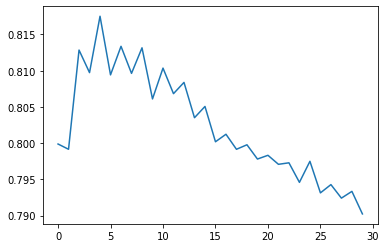

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV

#create a new KNN model
knn = KNeighborsClassifier()

scores = []

for hyperparameter in range(1, 31):
    knn_tmp = KNeighborsClassifier(n_neighbors = hyperparameter)
    cv_scores = cross_val_score(knn_tmp, X_train, y_train, cv = 10)
    scores.append(np.mean(cv_scores))
    
plt.plot(scores)
plt.show


#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 31)}

#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn, param_grid, cv = 10)
 
#fit model to data
knn_gscv.fit(X_train, y_train)

#check top performing n_neighbors value
print(knn_gscv.best_params_)
best_k = knn_gscv.best_params_['n_neighbors']

#check mean score for the top performing value of n_neighbors
print(knn_gscv.best_score_)

In [ ]:
# KNN approach 1
bcell_knn = KNeighborsClassifier(n_neighbors = best_k).fit(X_train, y_train)
bcell_knn_predicted = bcell_knn.predict(X_test)
print(accuracy_score(y_test, bcell_knn_predicted))

tn, fp, fn, tp = confusion_matrix(y_test, bcell_knn_predicted).ravel()
print((tn, fp, fn, tp))

print(classification_report(y_test, bcell_knn_predicted, target_names = ['0', '1']))


# KNN approach 2
sars_knn = KNeighborsClassifier(n_neighbors = 1).fit(bcell_X, bcell_y)
sars_knn_predicted = sars_knn.predict(sars_X)
print(accuracy_score(sars_y, sars_knn_predicted))

tn, fp, fn, tp = confusion_matrix(sars_y, sars_knn_predicted).ravel()
print((tn, fp, fn, tp))

print(classification_report(sars_y, sars_knn_predicted, target_names = ['0', '1']))

0.8226621735467565
(3184, 276, 566, 722)
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      3460
           1       0.72      0.56      0.63      1288

    accuracy                           0.82      4748
   macro avg       0.79      0.74      0.76      4748
weighted avg       0.81      0.82      0.81      4748

0.7038461538461539
(331, 49, 105, 35)
              precision    recall  f1-score   support

           0       0.76      0.87      0.81       380
           1       0.42      0.25      0.31       140

    accuracy                           0.70       520
   macro avg       0.59      0.56      0.56       520
weighted avg       0.67      0.70      0.68       520



## Support Vector Machine

SVM is a binary classification algorithm, which supports linear classification and nonlinear classification also regression as well. There are two important advantages of SVM: efficient in high space dimensional spaces; still effective when several dimensions are more than samples. However, there are too many samples’ features, SVM may easily cause the overfitting. 

In [ ]:
from sklearn import svm

# SVM approach 1
bcell_svm = svm.SVC(gamma='auto')
bcell_svm.fit(X_train, y_train)
bcell_svm_predicted = bcell_svm.predict(X_test)
print(accuracy_score(y_test, bcell_svm_predicted))

tn, fp, fn, tp = confusion_matrix(y_test, bcell_svm_predicted).ravel()
print((tn, fp, fn, tp))

print(classification_report(y_test, bcell_svm_predicted, target_names = ['0', '1']))


# SVM approach 2
sars_svm = svm.SVC(gamma='auto').fit(bcell_X, bcell_y)
sars_svm_predicted = sars_svm.predict(sars_X)
print(accuracy_score(sars_y, sars_svm_predicted))

tn, fp, fn, tp = confusion_matrix(sars_y, sars_svm_predicted).ravel()
print((tn, fp, fn, tp))

print(classification_report(sars_y, sars_svm_predicted, target_names = ['0', '1']))

0.8119208087615838
(3255, 205, 688, 600)
              precision    recall  f1-score   support

           0       0.83      0.94      0.88      3460
           1       0.75      0.47      0.57      1288

    accuracy                           0.81      4748
   macro avg       0.79      0.70      0.73      4748
weighted avg       0.80      0.81      0.80      4748

0.7557692307692307
(367, 13, 114, 26)
              precision    recall  f1-score   support

           0       0.76      0.97      0.85       380
           1       0.67      0.19      0.29       140

    accuracy                           0.76       520
   macro avg       0.71      0.58      0.57       520
weighted avg       0.74      0.76      0.70       520



## Decision Tree

A Decision Tree is an unsupervised learning method, the goal is to create a model that learns simple decision rules from data characteristics to predict the value of a target variable. The advantage is easy to understand and the tree can be visualized. Also, it can handle both continuous data and discrete data, and no need to standardize the distribution. The disadvantage is the model may be too complex due to large data, and the result may not be the global optimal solution.

In [ ]:
from sklearn import tree

X_train, X_test, y_train, y_test = train_test_split(bcell_X, bcell_y, test_size = 0.33, random_state = 1, stratify = bcell_y)

# Decision Tree approach 1
bcell_tree = tree.DecisionTreeClassifier()
bcell_tree.fit(X_train, y_train)
bcell_tree_predicted = bcell_tree.predict(X_test)
print(accuracy_score(y_test, bcell_tree_predicted))

tn, fp, fn, tp = confusion_matrix(y_test, bcell_tree_predicted).ravel()
print((tn, fp, fn, tp))

print(classification_report(y_test, bcell_tree_predicted, target_names = ['0', '1']))


# Decision Tree approach 2
sars_tree = tree.DecisionTreeClassifier().fit(bcell_X, bcell_y)
sars_tree_predicted = sars_tree.predict(sars_X)
print(accuracy_score(sars_y, sars_tree_predicted))

tn, fp, fn, tp = confusion_matrix(sars_y, sars_tree_predicted).ravel()
print((tn, fp, fn, tp))

print(classification_report(sars_y, sars_tree_predicted, target_names = ['0', '1']))

0.8034962089300758
(3008, 452, 481, 807)
              precision    recall  f1-score   support

           0       0.86      0.87      0.87      3460
           1       0.64      0.63      0.63      1288

    accuracy                           0.80      4748
   macro avg       0.75      0.75      0.75      4748
weighted avg       0.80      0.80      0.80      4748

0.5903846153846154
(273, 107, 106, 34)
              precision    recall  f1-score   support

           0       0.72      0.72      0.72       380
           1       0.24      0.24      0.24       140

    accuracy                           0.59       520
   macro avg       0.48      0.48      0.48       520
weighted avg       0.59      0.59      0.59       520



## XGBoost

XGBoost is an implementation of gradient boosted decision trees designed for speed and performance.

In [ ]:
from xgboost import XGBClassifier

X_train, X_test, y_train, y_test = train_test_split(bcell_X, bcell_y, test_size = 0.33, random_state = 1, stratify = bcell_y)

# XGBClassifer approach 1
bcell_xgb = XGBClassifier()
bcell_xgb.fit(X_train, y_train)
bcell_xgb_predicted = bcell_xgb.predict(X_test)
print(accuracy_score(y_test, bcell_xgb_predicted))

tn, fp, fn, tp = confusion_matrix(y_test, bcell_xgb_predicted).ravel()
print((tn, fp, fn, tp))

print(classification_report(y_test, bcell_xgb_predicted, target_names = ['0', '1']))


# XGBClassifer approach 2
sars_xgb = XGBClassifier().fit(bcell_X, bcell_y)
sars_xgb_predicted = sars_xgb.predict(sars_X)
print(accuracy_score(sars_y, sars_xgb_predicted))

tn, fp, fn, tp = confusion_matrix(sars_y, sars_xgb_predicted).ravel()
print((tn, fp, fn, tp))

print(classification_report(sars_y, sars_xgb_predicted, target_names = ['0', '1']))

0.817396798652064
(3261, 199, 668, 620)
              precision    recall  f1-score   support

           0       0.83      0.94      0.88      3460
           1       0.76      0.48      0.59      1288

    accuracy                           0.82      4748
   macro avg       0.79      0.71      0.74      4748
weighted avg       0.81      0.82      0.80      4748

0.6711538461538461
(314, 66, 105, 35)
              precision    recall  f1-score   support

           0       0.75      0.83      0.79       380
           1       0.35      0.25      0.29       140

    accuracy                           0.67       520
   macro avg       0.55      0.54      0.54       520
weighted avg       0.64      0.67      0.65       520



## ROC Curves

 Then we use the ROC curve to compare four models in same dataset where AUC measures the total area under each curve in a two-dimensional coordinate. The range of AUC can be between 0 and 1, the best case is TPR equals one and FPR equals zero. In general, the larger the area is, the better the performance.

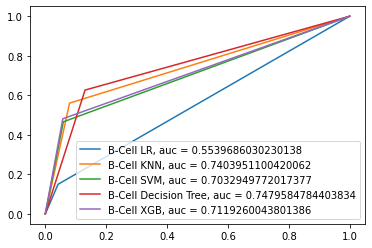

In [ ]:
# ROC curves
fpr, tpr, thresh = roc_curve(y_test, bcell_clf_predicted)
auc = roc_auc_score(y_test, bcell_clf_predicted)
plt.plot(fpr, tpr, label = "B-Cell LR, auc = " + str(auc))

fpr, tpr, thresh = roc_curve(y_test, bcell_knn_predicted)
auc = roc_auc_score(y_test, bcell_knn_predicted)
plt.plot(fpr, tpr, label = "B-Cell KNN, auc = " + str(auc))

fpr, tpr, thresh = roc_curve(y_test, bcell_svm_predicted)
auc = roc_auc_score(y_test, bcell_svm_predicted)
plt.plot(fpr, tpr, label = "B-Cell SVM, auc = " + str(auc))

fpr, tpr, thresh = roc_curve(y_test, bcell_tree_predicted)
auc = roc_auc_score(y_test, bcell_tree_predicted)
plt.plot(fpr, tpr, label = "B-Cell Decision Tree, auc = " + str(auc))

fpr, tpr, thresh = roc_curve(y_test, bcell_xgb_predicted)
auc = roc_auc_score(y_test, bcell_xgb_predicted)
plt.plot(fpr, tpr, label = "B-Cell XGB, auc = " + str(auc))

plt.legend(loc = 0)

plt.show()

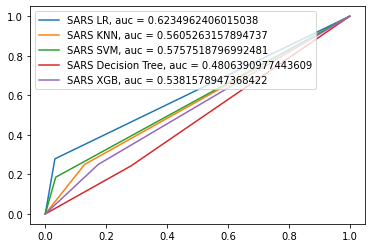

In [ ]:
fpr, tpr, thresh = roc_curve(sars_y, sars_clf_predicted)
auc = roc_auc_score(sars_y, sars_clf_predicted)
plt.plot(fpr, tpr, label = "SARS LR, auc = " + str(auc))

fpr, tpr, thresh = roc_curve(sars_y, sars_knn_predicted)
auc = roc_auc_score(sars_y, sars_knn_predicted)
plt.plot(fpr, tpr, label = "SARS KNN, auc = " + str(auc))

fpr, tpr, thresh = roc_curve(sars_y, sars_svm_predicted)
auc = roc_auc_score(sars_y, sars_svm_predicted)
plt.plot(fpr, tpr, label = "SARS SVM, auc = " + str(auc))

fpr, tpr, thresh = roc_curve(sars_y, sars_tree_predicted)
auc = roc_auc_score(sars_y, sars_tree_predicted)
plt.plot(fpr, tpr, label = "SARS Decision Tree, auc = " + str(auc))

fpr, tpr, thresh = roc_curve(sars_y, sars_xgb_predicted)
auc = roc_auc_score(sars_y, sars_xgb_predicted)
plt.plot(fpr, tpr, label = "SARS XGB, auc = " + str(auc))

plt.legend(loc = 0)

plt.show()

## Discussion

We used two approaches for every model, the first approach is to separate the B-cell data into a training set and test set, and see the result mainly in B-cell data; the second approach is to use B-cell as a training set, and SARS as test set, to observe the model performance beyond B-cell. These results show the performance in the same model between B-Cell and SARS. Support means the number of observations. 

In Logistic Regression, both scores of 0 predictions are higher than 1. We can see the recall and F1-score in B-Cell prediction has a huge difference, but the overall performance is pretty good, and the accuracy increased from 0.74 to 0.78 from B-Cell to SARS. 

In the KNN model and the SVM model, the gap has narrowed a little bit. Unlike Logistic Regression, the difference between 0 and 1 of precision and F1-score in both B-Cell and SARS are larger than Logistic Regression. 

In the Decision Tree and the XGBoost model, the performance is also has a huge variation between B-Cell and SARS.  The score of B-Cell is all above 0.5, especially for predicting Negative, they are almost near 90%. However, in the SARS dataset, the scores are generally low. Only the value of predicting the Positive recall has over 0.5.

The ROC curves shows KNN increases dramatically in the early stage and AUC is much higher than other models. Since SVM can only predict one target, so maybe that is the reason AUC equals 0.5. For the SARS roc curve, the Logistic Regression boost in haste and the true positive rate of Decision Tree ranges from 0 to 0.4, and the false-positive rate ranges from 0 to 0.8 in the early stage, which shows that this model is not so well-fitted.

Among all the models, we can see that Logistic Regression outperformed all other models with its f1-score and overall accuracy. The KNN and Support Vector Machine are the second and third models. It is easy to see that the Decision Tree is overfitting which suggests they are not suited for these data inputs. Since XGBoost is a tree structure with gradient boosting, it is no surprise to see that it is a bit overfitting as well. 

# Ensemble Learning Models

Since we have already used four models like LR, SVM, DT, KNN and XGBoost, some of the model performance is not as good as expected. so we decided to use Ensemble Learning methods like VotingClassifier and AdaBoostClassifier to obtain better predictive performance than could be obtained from any of the constituent learning algorithms alone by combining multiple learning methods.

## VotingClassifier

The reason why to choose VotingClassifier is that it is a vote-based classification. It evaluates the result of each test data specifically and decides on the side with the majority of votes. We use hard voting here. And AdaBoost is best used to boost the performance of decision trees on binary classification problems with weak learners. These are models that achieve accuracy just above random chance on a classification problem.

In [ ]:
# bagging using VotingClassifier
from sklearn. ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier

evc = VotingClassifier(estimators= [('sars_clf',sars_clf),('sars_knn',sars_knn),('sars_svm',sars_svm),('sars_tree',sars_tree),('sars_xgb',sars_xgb)], voting = 'hard')
evc.fit(bcell_X, bcell_y)

evc_predicted = evc.predict(sars_X)
print(accuracy_score(sars_y, evc_predicted))

tn, fp, fn, tp = confusion_matrix(sars_y, evc_predicted).ravel()
print((tn, fp, fn, tp))

print(classification_report(sars_y, evc_predicted, target_names = ['0', '1']))

0.7557692307692307
(368, 12, 115, 25)
              precision    recall  f1-score   support

           0       0.76      0.97      0.85       380
           1       0.68      0.18      0.28       140

    accuracy                           0.76       520
   macro avg       0.72      0.57      0.57       520
weighted avg       0.74      0.76      0.70       520



## AdaBoostClassifier

Unlike VotingClassifier, the most suited algorithm for AdaBoost is decision trees that are added sequentially to the ensemble. Each model attempts to correct the predictions made by the model before it is inserted into the sequence.

In [ ]:
# bagging using AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2, min_samples_split=20, min_samples_leaf=5),
                         algorithm="SAMME",
                         n_estimators=300, learning_rate=1.2)
bdt.fit(bcell_X, bcell_y)

bdt_predicted = bdt.predict(sars_X)
print(accuracy_score(sars_y, bdt_predicted))

tn, fp, fn, tp = confusion_matrix(sars_y, bdt_predicted).ravel()
print((tn, fp, fn, tp))

print(classification_report(sars_y, bdt_predicted, target_names = ['0', '1']))

0.7865384615384615
(370, 10, 101, 39)
              precision    recall  f1-score   support

           0       0.79      0.97      0.87       380
           1       0.80      0.28      0.41       140

    accuracy                           0.79       520
   macro avg       0.79      0.63      0.64       520
weighted avg       0.79      0.79      0.75       520



## RandomForestClassifier

We use the Random Forest algorithm to solve the binary classification problem. It is a type of ensemble machine learning algorithm called Bootstrap Aggregation or bagging. We set the range of estimators from 200 to 2000 step is 10, the max_depth is from 10 to 110, step is 11. Also, we use the cross-validation method to calculate the hyperparameter

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier()

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 10, verbose=2, random_state=42, n_jobs = -1)

# Fit on training data
rf_random.fit(bcell_X, bcell_y)

model = rf_random.best_estimator_

# Actual class predictions
rf_predictions = model.predict(sars_X)
# Probabilities for each class
rf_probs = model.predict_proba(sars_X)[:, 1]

print(accuracy_score(sars_y, rf_predictions))

tn, fp, fn, tp = confusion_matrix(sars_y, rf_predictions).ravel()
print((tn, fp, fn, tp))

print(classification_report(sars_y, rf_predictions, target_names = ['0', '1']))

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 32.4min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 79.9min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 128.0min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 194.4min finished


0.8
(372, 8, 96, 44)
              precision    recall  f1-score   support

           0       0.79      0.98      0.88       380
           1       0.85      0.31      0.46       140

    accuracy                           0.80       520
   macro avg       0.82      0.65      0.67       520
weighted avg       0.81      0.80      0.76       520



## Discussion

From the result, we can see the accuracy of Votingclassifier is 0.76, Adaboosting is 0.79 and Random Forest is 0.8. The score distribution of each method has no big difference. Except for precision in Adaboosting and Random Forest, the score of 0 are all higher than 1. The Random Forest is better than Votingclassifier and Adaboosting in almost every aspect, I think the reason is that the training data in Random Forest is based on bagging technique, which uses the subset of training data with replacement and uses the parallel ensemble. It can decrease the variance in the prediction and each weak learner has equal weight in bagging due to the ability to learn non-linear relationships and robustness to outliers since it uses multiple models to obtain better predictive performance by using ensembling methods and cross-validation to select the best number of trees.  

In Adaboosting, however, it uses the boosting technique, which sequentially considers each weak learner. The model outcomes will be weighted based on the previous result. If we go sequentially by putting more weight on instances with wrong predictions and high errors, the model learns from past mistakes. Here the dataset is not that perfect since 1 is almost two-thirds less than 0, so it may cause little difference between sequential learning and parallel learning. 

Overall, the gap among these three ensemble Learning methods is very small, and all better than the individual weak learner. We can say that the ensemble learning method plays an important role in improving the performance of building models in this target.


# Alternate Approach of KNN

The implantation below is another approach of the K-Nearest Neighbor, where instead of Euclidean Distance between two features, we used the similarity between two peptide sequences as distance. The reason to do so is that in theory, the higher the similarity score between two sequences, the higher the chance they perform the same function (they belong to the same family) so that they are closer. In this algorithm, the original idea was to use BLAST to perform sequence alignment, but it took too long, so we used Levenshtein distance as a string metric for measuring the difference between two sequences instead. The algorithm also includes 5-fold cross-validation to select the best hyperparameter k from 1 to 100. 

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


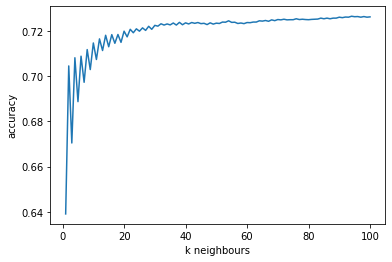

best # of neighbours k: 94
best cross validation accuracy: 0.7264160919690155
test accuracy: 0.7307692307692307


In [ ]:
! pip install python-Levenshtein

import Levenshtein
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV

bcell_peptide = bcell['peptide_seq'].to_numpy()
sars_peptide = sars['peptide_seq'].to_numpy()

def my_blast(seq1, seq2):
  similarity = Levenshtein.distance(seq1, seq2)
  return int(similarity)

def predict_knn(x, inputs, labels, k_neighbours):
  l2_distances = []
  for y in inputs:
    dist = my_blast(x, y)
    l2_distances.append(dist)
  indices = np.argsort(l2_distances)
  neighbour_labels = labels[indices[range(k_neighbours)]]
  unique_labels, counts = np.unique(neighbour_labels, return_counts=True)
  best_index = np.argmax(counts)
  predicted_label = unique_labels[best_index]
  return predicted_label

def eval_knn(inputs, labels, train_inputs, train_labels, k_neighbours):
  correct = 0
  for id in range(len(labels)):
    x = inputs[id]
    predicted_label = predict_knn(x, train_inputs, train_labels, k_neighbours)
    if labels[id] == predicted_label:
      correct += 1
  accuracy = correct / len(labels)  
  return accuracy

def cross_validation_knn(k_folds, hyperparameters, inputs, labels):
  fold_size = len(labels)/k_folds
  accuracies = np.zeros(len(hyperparameters))
  for id, hyperparam in enumerate(hyperparameters):
    print(hyperparam)
    for fold in range(k_folds):
      validation_inputs = inputs[int(round(fold*fold_size)):
                                 int(round((fold+1)*fold_size))]
      validation_labels = labels[int(round(fold*fold_size)):
                                 int(round((fold+1)*fold_size))]
      train_inputs = np.concatenate((inputs[:int(round(fold*fold_size))],
                                     inputs[int(round((fold+1)*fold_size)):]))
      train_labels = np.concatenate((labels[:int(round(fold*fold_size))],
                                     labels[int(round((fold+1)*fold_size)):]))
      accuracies[id] += eval_knn(validation_inputs, validation_labels, 
                                 train_inputs, train_labels, hyperparam)
  accuracies /= k_folds
  best_accuracy = np.max(accuracies)
  best_hyperparam = hyperparameters[np.argmax(accuracies)]
  return best_hyperparam, best_accuracy, accuracies

def plot_knn_accuracies(accuracies,hyperparams):
  plt.plot(hyperparams,accuracies)
  plt.ylabel('accuracy')
  plt.xlabel('k neighbours')
  plt.show()  

# number of neighbours to be evaluated by cross validation
hyperparams = range(1, 101)
k_folds = 5
best_k_neighbours, best_accuracy, accuracies = cross_validation_knn(k_folds, hyperparams, bcell_peptide, bcell_y)

# plot results
plot_knn_accuracies(accuracies, hyperparams)
print('best # of neighbours k: ' + str(best_k_neighbours))
print('best cross validation accuracy: ' + str(best_accuracy))

# evaluate with best # of neighbours
accuracy = eval_knn(sars_peptide, sars_y, bcell_peptide, bcell_y, best_k_neighbours)
print('test accuracy: '+ str(accuracy))


## Discussion

After the entire process of this algorithm, we can see that the best k is 94 with cross-validation. The accuracy did not improve much as they are still around 0.72 and 0.73, which suggests only the similarity between peptide sequences cannot provide enough information. However, the overall performance improved since the original KNN was a little overfitting, but the alternate approach is not. 

# Result

In this project, we compare various Machine Learning models to see which ones perform the best to predict B-Cell epitope and SARS. Overall, the logistic regression performs the best among all single models, and Random Forest performs the best among the ensemble models. 

For future work, we hope we can build a more robust model for peptide sequence pre-processing based on the amino acid’s property instead of one-hot encoding in order to increase the accuracy. Moreover, we want to use this model to not only predict SARS with the epitope region but also the Covid-19 as well and apply it to various viruses in the future.
